# Proyecto 4
## Whale Calls
Grupo 8 (Random Clustering)

In [ ]:
import numpy as np
import math
import pandas as pd
import random
import matplotlib.pyplot as plt
import cvxopt
import seaborn as sns
import itertools
import pywt
import os
from sklearn.metrics import confusion_matrix, f1_score, precision_score, recall_score

# Libreria de extracción de características

La librería a usar para la extracción de características es Librosa.



In [ ]:
import librosa
import matplotlib.pylab as plt

from IPython.display import Audio

# Dataset

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')
# "Rewrite the path in case your dataset is located in a different directory on your drive.

path = '/content/drive/MyDrive/P4/Whales Dataset'
# path = '/content/drive/MyDrive/{}'.format("1VfthX0TIhDMsc7rp3ES6ApVwdBLSK4_e")

Mounted at /content/drive/


In [ ]:
y, sr = librosa.load(path + "/test/test/14.wav" )
mfccs = librosa.feature.mfcc(y=y, sr=sr)
feacture_vector = np.array(mfccs.mean(axis = 1))
print("Feature Vector of the whale sound :" , feacture_vector)
Audio(data=y, rate=sr)

Feature Vector of the whale sound : [-613.6703     250.5857     148.60298     36.87065    -45.3932
  -73.59026    -53.50069    -12.878029    17.368847    20.958157
    2.3202772  -20.739542   -31.16245    -23.767595    -6.512374
    7.1829457    8.571262    -0.9993999  -12.571845   -17.02471  ]


In [ ]:
def encode(path, data_type='train', label_map=None):
    data = []
    labels = []

    sub_directory = os.path.join(path, data_type, data_type)
    if data_type == 'train':
        csv_file = os.path.join(path, data_type + '.csv')
        annotations = pd.read_csv(csv_file)

        for idx, row in annotations.iterrows():
            # Si `idx` no contiene la extensión del archivo, agrega la extensión adecuada
            file_name = str(row['idx'])
            if not file_name.endswith('.wav'):  # Suponiendo que los archivos de audio tienen extensión .wav
                file_name += '.wav'

            file_path = os.path.join(sub_directory, file_name)

            if os.path.exists(file_path):
                y, sr = librosa.load(file_path)
                mfccs = librosa.feature.mfcc(y=y, sr=sr)
                fv = mfccs.mean(axis=1)
                data.append(fv)
                labels.append(label_map[row['class']])
            else:
                print(f"File {file_path} not found.")
    else:
        directory = os.listdir(sub_directory)
        for file_name in directory:
            file_path = os.path.join(sub_directory, file_name)
            if os.path.isfile(file_path):
                y, sr = librosa.load(file_path)
                mfccs = librosa.feature.mfcc(y=y, sr=sr)
                fv = mfccs.mean(axis=1)
                data.append(fv)
                labels.append(0)  # Asignar etiqueta dummy, ya que no tenemos información de las clases en test

    data = np.array(data)
    labels = np.array(labels)

    return data, labels

## Encoding del dataset

In [ ]:
# Si NO los tengo guardados ejecuto esto

label_map = {'NoWhale': 0, 'RightWhale': 1}

x_train_lr, y_train_lr = encode(path, 'train', label_map)
x_test_lr, y_test_lr = encode(path, 'test', label_map)

#Guardo los resultados del encoding
import pickle

# Ruta para guardar los resultados
train_data_file = '/content/drive/MyDrive/P4/Whales Dataset/train_data.pkl'
test_data_file = '/content/drive/MyDrive/P4/Whales Dataset/test_data.pkl'

with open(train_data_file, 'wb') as f:
  pickle.dump((x_train_lr, y_train_lr), f)

with open(test_data_file, 'wb') as f:
  pickle.dump((x_test_lr, y_test_lr), f)


NameError: name 'path' is not defined

In [ ]:
# Si ya los tengo guardados ejecuto esto
import pickle

train_data_file = '/content/drive/MyDrive/P4/Whales Dataset/train_data.pkl'
test_data_file = '/content/drive/MyDrive/P4/Whales Dataset/test_data.pkl'

def load_encoded_data(file_path):
  with open(file_path, 'rb') as f:
    x, y = pickle.load(f)
  return x, y

x_train_lr, y_train_lr = load_encoded_data(train_data_file)
x_test_lr, y_test_lr = load_encoded_data(test_data_file)

#Normalización

In [ ]:
# Normalizacion
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
x_train_norm = scaler.fit_transform(x_train_lr)
x_test_norm = scaler.transform(x_test_lr)

Destinamos el 80% de los audios con etiquetas a modo de entrenamiento y el 20% a modo de testing

In [ ]:
from sklearn.model_selection import train_test_split

x_train_norm_80, x_train_norm_20, y_train_lr_80, y_train_lr_20 = train_test_split(x_train_norm, y_train_lr, test_size=0.2, random_state=42)

In [ ]:
# Dataset

print("Distribución de clases en y_train:")
print(pd.Series(y_train_lr).value_counts())

print("Número de samples en y_test:")
print(len(y_test_lr))

# Por la segmentación descrita, tenemos lo siguiente

print("Distribución de clases en y_train_80 (destinado a Train):")
print(pd.Series(y_train_lr_80).value_counts())

print("Distribución de clases en y_train_20 (destinado a Test):")
print(pd.Series(y_train_lr_20).value_counts())

Distribución de clases en y_train:
0    5467
1    5467
Name: count, dtype: int64
Número de samples en y_test:
1962
Distribución de clases en y_train_80 (destinado a Train):
0    4408
1    4339
Name: count, dtype: int64
Distribución de clases en y_train_20 (destinado a Test):
1    1128
0    1059
Name: count, dtype: int64


In [ ]:
def matriz_confusion(y_test, y_pred, Tipo):
  matrix = confusion_matrix(y_test, y_pred)
  f2 = pd.DataFrame(matrix.astype('float') / matrix.sum(axis=1)[:, np.newaxis], index=["NoWhale", "RightWhale"], columns=["NoWhale", "RightWhale"])
  sns.heatmap(f2, annot=True, cbar=None, cmap="Greens")
  plt.title("Confusion Matrix " + Tipo)
  plt.tight_layout()
  plt.xlabel("Predicted")
  plt.ylabel("Real")
  plt.show()

# MLP Model Approach

In [ ]:
import torch
import pandas as pd
from torch import nn
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, f1_score, precision_score, recall_score, accuracy_score

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

x_train_tensor = torch.tensor(x_train_norm_80, dtype=torch.float32).to(device)
y_train_tensor = torch.tensor(y_train_lr_80, dtype=torch.float32).to(device)

x_test_tensor = torch.tensor(x_train_norm_20, dtype=torch.float32).to(device)
y_test_tensor = torch.tensor(y_train_lr_20, dtype=torch.float32).to(device)

# Write your code here
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

cpu
cpu


In [ ]:
class ImprovedMLP_Relu(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(ImprovedMLP_Relu, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.bn1 = nn.BatchNorm1d(hidden_size)
        self.relu1 = nn.ReLU()
        self.dropout1 = nn.Dropout(0.2)
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.bn2 = nn.BatchNorm1d(hidden_size)
        self.relu2 = nn.ReLU()
        self.dropout2 = nn.Dropout(0.2)
        self.fc3 = nn.Linear(hidden_size, 1)

    def forward(self, x):
        x = self.fc1(x)
        x = self.bn1(x)
        x = self.relu1(x)
        x = self.dropout1(x)
        x = self.fc2(x)
        x = self.bn2(x)
        x = self.relu2(x)
        x = self.dropout2(x)
        x = self.fc3(x)
        return x

In [ ]:
class ImprovedMLP_LRelu(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(ImprovedMLP_LRelu, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.bn1 = nn.BatchNorm1d(hidden_size)
        self.leaky_relu1 = nn.LeakyReLU()
        self.dropout1 = nn.Dropout(0.2)
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.bn2 = nn.BatchNorm1d(hidden_size)
        self.leaky_relu2 = nn.LeakyReLU()
        self.dropout2 = nn.Dropout(0.2)
        self.fc3 = nn.Linear(hidden_size, 1)

    def forward(self, x):
        x = self.fc1(x)
        x = self.bn1(x)
        x = self.leaky_relu1(x)
        x = self.dropout1(x)
        x = self.fc2(x)
        x = self.bn2(x)
        x = self.leaky_relu2(x)
        x = self.dropout2(x)
        x = self.fc3(x)
        return x

In [ ]:
def train(model, loss_f, optimizer, epochs, x_train, y_train, batch_size=32):
    loss_lista = []
    model.train()

    dataset = torch.utils.data.TensorDataset(x_train, y_train)
    train_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)

    for epoch in range(epochs):
        epoch_loss = 0
        for x_batch, y_batch in train_loader:
            # Propagación adelante
            y_pred = model(x_batch).squeeze()
            loss = loss_f(y_pred, y_batch)
            loss_lista.append(loss.item())

            # Backpropagation
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()

        if epoch % 500 == 0:
            print('Epoch {}: train loss: {}'.format(epoch, epoch_loss / len(train_loader)))

    return loss_lista

In [ ]:
import torch.optim as optim

input_size = x_train_norm.shape[1]
model = ImprovedMLP_LRelu(input_size, 64).to(device)
loss_f = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)

## Training

In [ ]:
# Entrenar el modelo
epochs = 2100
losses = train(model, loss_f, optimizer, epochs, x_train_tensor, y_train_tensor)

Epoch 0: train loss: 0.5021854396501597
Epoch 500: train loss: 0.42633986832016574
Epoch 1000: train loss: 0.41952057481899746
Epoch 1500: train loss: 0.4228824276449907
Epoch 2000: train loss: 0.423095704212676


## Test

In [ ]:
# Write your code here
import seaborn as sns

def test(model, data_loader, device):
    model.eval()  # Poner el modelo en modo de evaluación
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for x, y in data_loader:
            x, y = x.to(device), y.to(device)
            preds = model(x).squeeze()
            all_preds.append(preds)
            all_labels.append(y)

    return torch.cat(all_preds, dim=0), torch.cat(all_labels, dim=0)

# Crear DataLoader de test
test_dataset = torch.utils.data.TensorDataset(x_test_tensor, y_test_tensor)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=False)

# Generar predicciones y etiquetas reales
y_pred, y_test = test(model, test_loader, device)

# Convertir las predicciones a etiquetas
y_pred_labels = (torch.sigmoid(y_pred) > 0.5).int()

In [ ]:
y_test_np = y_train_lr_20 # note (20% destinado)
y_pred_labels_np = y_pred_labels.cpu().numpy()

# Calcula las métricas
accuracy = accuracy_score(y_test_np, y_pred_labels_np)
precision = precision_score(y_test_np, y_pred_labels_np)
recall = recall_score(y_test_np, y_pred_labels_np)
f1 = f1_score(y_test_np, y_pred_labels_np)

print("Accuracy: ", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1-score:", f1)

Accuracy:  0.7892089620484682
Precision: 0.7833474936278675
Recall: 0.8173758865248227
F1-score: 0.8


In [ ]:
print("Distribución de clases en y_test:")
print(pd.Series(y_test_np).value_counts())

print("Distribución de clases en y_pred_labels:")
print(pd.Series(y_pred_labels_np.flatten()).value_counts())

Distribución de clases en y_test:
1    1128
0    1059
Name: count, dtype: int64
Distribución de clases en y_pred_labels:
1    1240
0     947
Name: count, dtype: int64


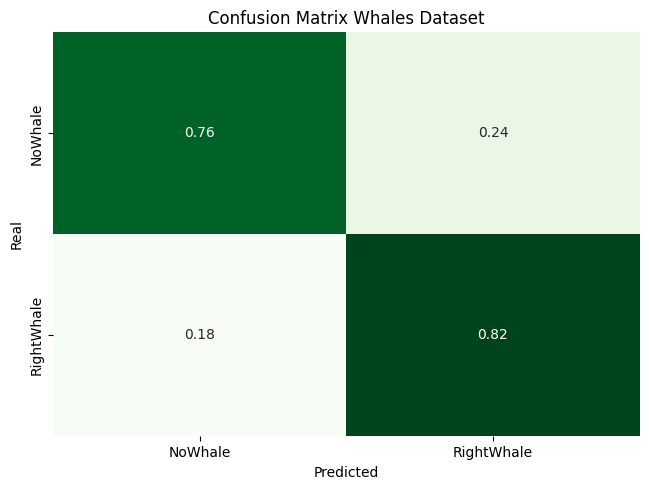

In [ ]:
matriz_confusion(y_train_lr_20, y_pred_labels.cpu().numpy(), "Whales Dataset")

## Prueba con audios de Test
Para subida a Kaggle

In [ ]:
x_test_tensor = torch.tensor(x_test_norm, dtype=torch.float32).to(device)
y_test_tensor = torch.tensor(y_test_lr, dtype=torch.float32).to(device)

# Write your code here
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

cpu


In [ ]:
# Crear DataLoader de test
test_dataset = torch.utils.data.TensorDataset(x_test_tensor, y_test_tensor)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=False)

# Generar predicciones y etiquetas reales
y_pred, y_test = test(model, test_loader, device)

# Convertir las predicciones a etiquetas
y_pred_labels = (torch.sigmoid(y_pred) > 0.5).int()

In [ ]:
y_test_np = y_test_lr
y_pred_labels_np = y_pred_labels.cpu().numpy()

In [ ]:
label_map_inv = {0: 'NoWhale', 1: 'RightWhale'}
y_pred_classes = [label_map_inv[label] for label in y_pred_labels_np]

results_df = pd.DataFrame({
    'idx': [i for i in range(len(y_pred_classes))],
    'class': y_pred_classes
})

results_df.to_csv('/content/drive/MyDrive/P4/Whales Dataset/test_predictions.csv', index=False)

# SVM Approach

In [ ]:
def h(X, w, b):
    return np.dot(X, w.T) + b

def loss(y, y_aprox, C, w):
    hinge_loss = np.maximum(0, 1 - y * y_aprox)
    return 0.5 * (np.linalg.norm(w)**2) + C * np.sum(hinge_loss)

def derivatives(X, y, y_aprox, w, C):
    hinge_loss = np.maximum(0, 1 - y * y_aprox)
    dw = w + C * np.sum(-y[:, np.newaxis] * X * (hinge_loss > 0)[:, np.newaxis], axis=0)
    db = C * np.sum(-y * (hinge_loss > 0))
    return db, dw

def update(w, b, db, dw, alpha):
    w = w - alpha * dw
    b = b - alpha * db
    return w, b

def training(X, Y, C, alpha, epochs):
    w = np.random.randn(X.shape[1]) * 0.01
    b = np.random.randn() * 0.01
    error = []
    for i in range(epochs):
        Y_aprox = h(X, w, b)
        db, dw = derivatives(X, Y, Y_aprox, w, C)
        w, b = update(w, b, db, dw, alpha)
        L = loss(Y, Y_aprox, C, w)
        error.append(L)
        if (i + 1) % 100 == 0:
            #print("w norm: ", np.linalg.norm(w)**2)
            print(f'Epoch {i + 1}/{epochs}, Loss: {L}')
    return w, b, error

def testing(X, w, b):
    y_aprox = np.sign(h(X, w, b))
    y_aprox = (y_aprox + 1) // 2
    return y_aprox

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC

param_grid = {'C': [0.01, 0.1, 1, 10]}

svm_model = SVC(kernel='linear')

grid_search = GridSearchCV(svm_model, param_grid, cv=5, scoring='accuracy')
grid_search.fit(x_train_norm, y_train_lr)

best_model = grid_search.best_estimator_
best_C = grid_search.best_params_['C']
print(f"Mejor valor de C encontrado: {best_C}")

In [ ]:
#x_train_lr, y_train_lr
C = 1e-6
alpha = 1e-3
epochs = 2500
w, b, errors = training(x_train_norm_80, y_train_lr_80, C, alpha, epochs)

Epoch 100/2500, Loss: 0.010223698797927361
Epoch 200/2500, Loss: 0.009954777026774742
Epoch 300/2500, Loss: 0.009734273322377826
Epoch 400/2500, Loss: 0.00955340706820567
Epoch 500/2500, Loss: 0.009404990017429156
Epoch 600/2500, Loss: 0.009283137515324245
Epoch 700/2500, Loss: 0.009183032091781649
Epoch 800/2500, Loss: 0.009100729926547403
Epoch 900/2500, Loss: 0.009033002412178673
Epoch 1000/2500, Loss: 0.008977206449706811
Epoch 1100/2500, Loss: 0.008931178266301043
Epoch 1200/2500, Loss: 0.008893146489193537
Epoch 1300/2500, Loss: 0.008861660983723131
Epoch 1400/2500, Loss: 0.008835534596658914
Epoch 1500/2500, Loss: 0.00881379546441832
Epoch 1600/2500, Loss: 0.008795647970225898
Epoch 1700/2500, Loss: 0.008780440781719061
Epoch 1800/2500, Loss: 0.008767640684955225
Epoch 1900/2500, Loss: 0.008756811163637702
Epoch 2000/2500, Loss: 0.008747594863010726
Epoch 2100/2500, Loss: 0.008739699233935654
Epoch 2200/2500, Loss: 0.00873288478041984
Epoch 2300/2500, Loss: 0.00872695543846008
E

In [ ]:
y_pred_SVM = testing(x_train_norm_20, w, b)
print("Distribución de clases en y_pred_SVM:")
print(pd.Series((y_pred_SVM.flatten())).value_counts())

Distribución de clases en y_pred_SVM:
1.0    1380
0.0     807
Name: count, dtype: int64


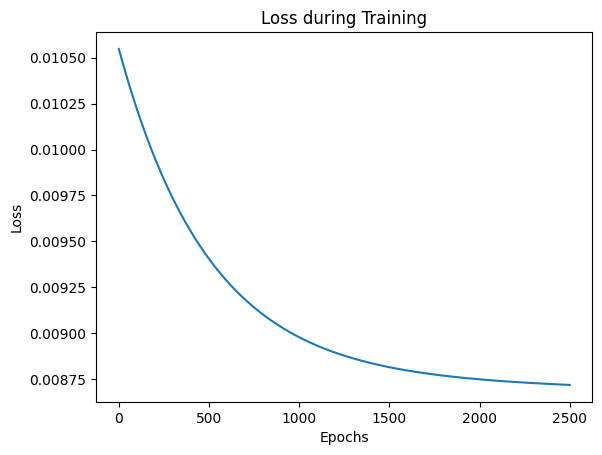

In [ ]:
plt.plot(errors)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss during Training')
plt.show()

In [ ]:
y_test_np = y_train_lr_20 # note (20% destinado)
y_pred_labels_np = y_pred_SVM

# Calcula las métricas
accuracy = accuracy_score(y_test_np, y_pred_labels_np)
precision = precision_score(y_test_np, y_pred_labels_np)
recall = recall_score(y_test_np, y_pred_labels_np)
f1 = f1_score(y_test_np, y_pred_labels_np)

print("Accuracy: ", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1-score:", f1)


Precision: 0.6942028985507246
Recall: 0.8953271028037383
F1-score: 0.7820408163265306


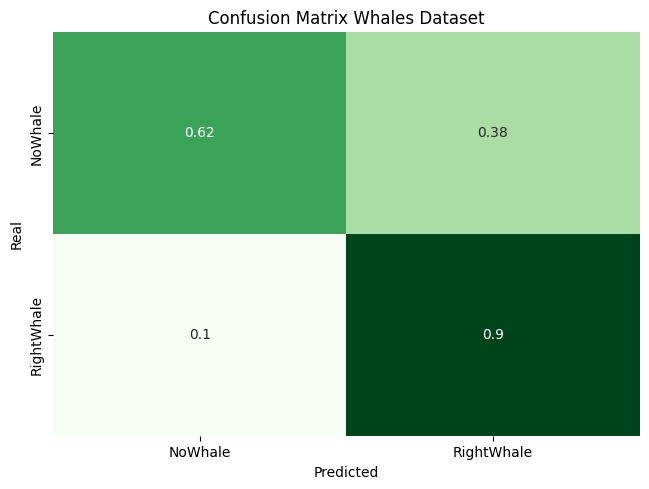

In [ ]:
matriz_confusion(y_train_lr_20, y_pred_labels_np, "Whales Dataset")

# Prueba con audios de Test
Para subida a Kaggle

In [ ]:
y_pred_SVM = testing(x_test_norm, w, b)
print("Distribución de clases en y_pred_SVM:")
print(pd.Series((y_pred_SVM.flatten())).value_counts())

Distribución de clases en y_pred_SVM:
1.0    1249
0.0     713
Name: count, dtype: int64


In [ ]:
label_map_inv = {0: 'NoWhale', 1: 'RightWhale'}
y_pred_classes = [label_map_inv[label] for label in y_pred_SVM]

results_df = pd.DataFrame({
    'idx': [i for i in range(len(y_pred_classes))],
    'class': y_pred_classes
})

results_df.to_csv('/content/drive/MyDrive/P4/Whales Dataset/test_predictions_svm.csv', index=False)

# Logistic Regression Approach

In [ ]:
class logistic_reg:
  def __init__(self):
    np.random.seed(2024)
    self.epsilon = 1e-8

  def h(self, x, w):
    return np.dot(x,w)

  def S(self, x, w):
    return 1 / ( 1 + (np.e ** -self.h(x,w)))

  def Loss(self, y, y_approx):
    y_approx[y_approx <= self.epsilon] = self.epsilon
    y_approx[y_approx >= 1 - self.epsilon] = 1 - self.epsilon

    v = y*np.log10(y_approx) + (1-y)*np.log10(1-y_approx)
    return -np.mean(v)

  def Derivatives(self, x, y, w):
    return np.matmul(y - self.S(x, w), -x) / len(y)

  def change_parameters(self, w, derivatives, alpha):
    return w - (alpha * derivatives)

  def training(self, x, y, epochs, alpha):
    L_value = []
    n_features = x.shape[1]
    w = np.array([np.random.rand() for i in range(n_features)])
    for i in range(epochs):
      L =  self.Loss(y, self.S(x, w))
      dw = self.Derivatives(x,y,w)
      w =  self.change_parameters(w, dw, alpha)
      L_value.append(L)
      if i % 500 == 0:
        print('Epoch {}: train loss: {}'.format(i, L))
    return L_value,w

  def test(self, x_test, y_test,w):
    n = len(y_test)
    y_pred = []
    matches = 0
    for i in range(n):
      pred = self.S(x_test[i], w)
      y_pred.append(pred)
      if (round(pred) == y_test[i]):
        matches += 1
    print("Number of correct data: ", matches, " out of ", n)
    print("Accuracy: ", matches/n)

In [ ]:
# agregar bias
ones_column = np.ones((x_train_norm_80.shape[0], 1))
x_train_norm_hstack = np.hstack((ones_column, x_train_norm_80))

Epoch 0: train loss: 1.8273682624928411
Epoch 500: train loss: 1.6515252050381657
Epoch 1000: train loss: 1.477934000557478
Epoch 1500: train loss: 1.309412460549349
Epoch 2000: train loss: 1.147780884290255


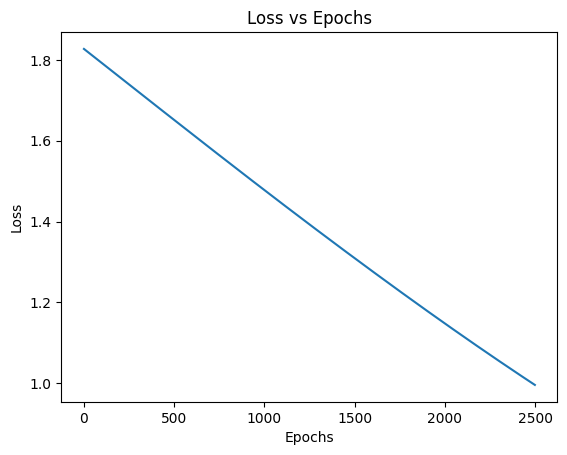

In [ ]:
# hyperparametros
epochs = 2500
alpha = 2e-4
lr_model = logistic_reg()
L,W = lr_model.training(x_train_norm_hstack, y_train_lr_80, epochs, alpha)
# plot
epochs_list = [i for i in range(epochs)]
plt.plot(epochs_list ,L)
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Loss vs Epochs")
plt.show()

## Testing


In [ ]:
# Testing
ones_column = np.ones((x_train_norm_20.shape[0], 1))
x_test_norm_hstack = np.hstack((ones_column, x_train_norm_20))

lr_model.test(x_test_norm_hstack, y_train_lr_20, W)

Number of correct data:  673  out of  2187
Accuracy:  0.30772748056698673


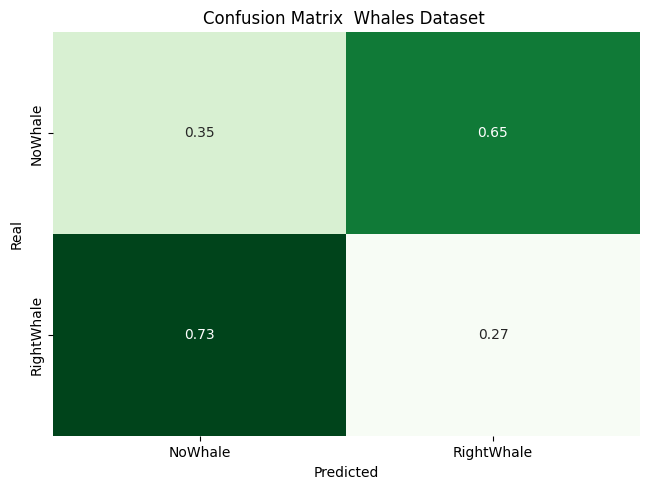

In [ ]:
y_pred_log = lr_model.S(x_test_norm_hstack, W)
y_pred_log = np.where(y_pred_log < 0.5, 0, 1)
matriz_confusion(y_train_lr_20,y_pred_log," Whales Dataset ")

In [ ]:
y_test_np = y_train_lr_20 # note (20% destinado)
y_pred_labels_np = y_pred_log

# Calcula las métricas
accuracy = accuracy_score(y_test_np, y_pred_labels_np)
precision = precision_score(y_test_np, y_pred_labels_np)
recall = recall_score(y_test_np, y_pred_labels_np)
f1 = f1_score(y_test_np, y_pred_labels_np)

print("Acccuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1-score:", f1)

Acccuracy: 0.30772748056698673
Precision: 0.30465587044534415
Recall: 0.26684397163120566
F1-score: 0.2844990548204159


# Pruebas con audios de Test
Para subida a Kaggle

In [ ]:
ones_column = np.ones((x_test_norm.shape[0], 1))
k_x_test_norm_hstack = np.hstack((ones_column, x_test_norm))

lr_model.test(k_x_test_norm_hstack, y_test_lr, W) # Se ignora el accuracy al no tener etiquetas para los audios de test (y_test_lr tiene valores por default en 0)

Number of correct data:  899  out of  1962
Accuracy:  0.4582059123343527


In [ ]:
y_pred_log = lr_model.S(k_x_test_norm_hstack, W)
y_pred_log = np.where(y_pred_log < 0.5, 0, 1)

In [ ]:
label_map_inv = {0: 'NoWhale', 1: 'RightWhale'}
y_pred_classes = [label_map_inv[label] for label in y_pred_log]

results_df = pd.DataFrame({
    'idx': [i for i in range(len(y_pred_classes))],
    'class': y_pred_classes
})

results_df.to_csv('/content/drive/MyDrive/P4/Whales Dataset/test_predictions_log.csv', index=False)

# Decision Tree Approach

## Usando Information Gain

In [ ]:
from collections import Counter

class Nodo:
    def __init__(self, index=None, threshold=None, left=None, right=None, value=None):
        self.index = index
        self.threshold = threshold
        self.left = left
        self.right = right
        self.value = value

    def IsTerminal(self, Y):
        return len(set(Y)) == 1

    def Entropy(self, Y):
        histogram = Counter(Y)
        probabilities = [freq / len(Y) for freq in histogram.values()]
        return -sum(p * np.log2(p) for p in probabilities if p > 0)

    def BestSplit(self, X, Y):
        best_gain = -1
        best_feature, best_threshold = None, None
        num_samples, num_features = X.shape

        current_entropy = self.Entropy(Y)

        for feature_index in range(num_features):
            thresholds = set(X[:, feature_index])
            for threshold in thresholds:
                left_mask = X[:, feature_index] <= threshold
                right_mask = X[:, feature_index] > threshold
                left_y, right_y = Y[left_mask], Y[right_mask]
                if len(left_y) == 0 or len(right_y) == 0:
                    continue

                left_entropy = self.Entropy(left_y)
                right_entropy = self.Entropy(right_y)
                p_left = len(left_y) / len(Y)
                gain = current_entropy - (p_left * left_entropy + (1 - p_left) * right_entropy)

                if gain > best_gain:
                    best_gain = gain
                    best_feature = feature_index
                    best_threshold = threshold

        return best_feature, best_threshold

    def Gini(self, Y):
        histo = Counter(Y)
        total = sum(histo.values())
        gini = 1 - sum((count / total) ** 2 for count in histo.values())
        return gini


class DT:
    def __init__(self):
        self.m_Root = None

    def create_DT(self, X, Y, depth=0):
        self.m_Root = self._build_tree(X, Y, depth)

    def _build_tree(self, X, Y, depth):
        node = Nodo()
        if node.IsTerminal(Y):
            node.value = Counter(Y).most_common(1)[0][0]
            return node

        best_feature, best_threshold = self.Find_Best_Split(X, Y)
        if best_feature is None:
            node.value = Counter(Y).most_common(1)[0][0]
            return node

        left_mask = X[:, best_feature] <= best_threshold
        right_mask = X[:, best_feature] > best_threshold
        left_X, right_X = X[left_mask], X[right_mask]
        left_Y, right_Y = Y[left_mask], Y[right_mask]

        node.index = best_feature
        node.threshold = best_threshold

        node.left = self._build_tree(left_X, left_Y, depth + 1)
        node.right = self._build_tree(right_X, right_Y, depth + 1)

        return node

    def Find_Best_Split(self, X, Y):
        node = Nodo()
        return node.BestSplit(X, Y)

    def _predict_one(self, x):
        node = self.m_Root
        while node.value is None:
            if x[node.index] <= node.threshold:
                node = node.left
            else:
                node = node.right
        return node.value


def dt_predict(X, Y, X_new):
    print('DT 1')
    tree_model = DT()

    # Entrenar el modelo
    print('DT 2')
    tree_model.create_DT(X, Y)

    print('DT 3')
    # Realizar las predicciones
    Y_pred = np.array([tree_model._predict_one(x) for x in X_new])
    print('DT 4')

    return Y_pred

In [ ]:
# Training y test
from sklearn.metrics import accuracy_score

res = dt_predict(x_train_norm_80, y_train_lr_80, x_train_norm_20)

DT 1
DT 2
Depth: 0, Feature: 10, Threshold: 0.37832415103912354
Left distribution: Counter({1: 4116, 0: 2327})
Right distribution: Counter({0: 2081, 1: 223})
Depth: 1, Feature: 19, Threshold: -0.5041722059249878
Left distribution: Counter({1: 2522, 0: 642})
Right distribution: Counter({0: 1685, 1: 1594})
Depth: 2, Feature: 6, Threshold: -0.6792789101600647
Left distribution: Counter({1: 1580, 0: 246})
Right distribution: Counter({1: 942, 0: 396})
Depth: 3, Feature: 19, Threshold: -0.9732266664505005
Left distribution: Counter({1: 918, 0: 85})
Right distribution: Counter({1: 662, 0: 161})
Depth: 4, Feature: 1, Threshold: 0.9422665238380432
Left distribution: Counter({1: 368, 0: 57})
Right distribution: Counter({1: 550, 0: 28})
Depth: 5, Feature: 0, Threshold: 0.743462324142456
Left distribution: Counter({1: 220, 0: 50})
Right distribution: Counter({1: 148, 0: 7})
Depth: 6, Feature: 1, Threshold: 0.5468096733093262
Left distribution: Counter({1: 42, 0: 21})
Right distribution: Counter({1

In [ ]:
score = accuracy_score(y_train_lr_20, np.array(res))
print("Accuracy: ",score)

Accuracy:  0.7169638774577046


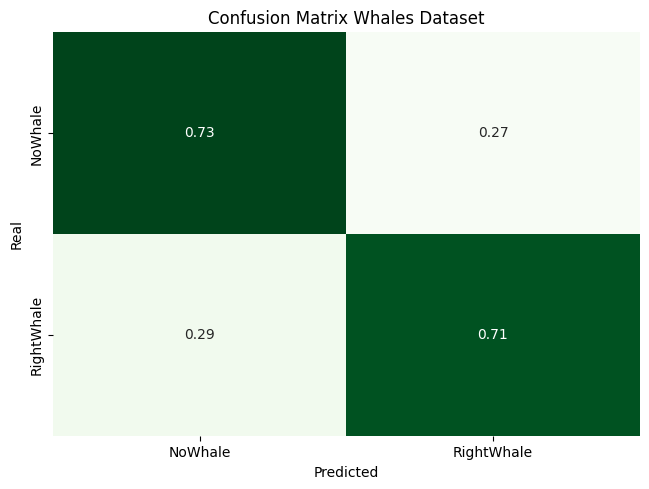

In [ ]:
matriz_confusion(y_train_lr_20, np.array(res), "Whales Dataset")

In [ ]:
y_test_np = y_train_lr_20 # note (20% destinado)
y_pred_labels_np = np.array(res)

# Calcula las métricas
precision = precision_score(y_test_np, y_pred_labels_np)
recall = recall_score(y_test_np, y_pred_labels_np)
f1 = f1_score(y_test_np, y_pred_labels_np)

print("\nPrecision:", precision)
print("Recall:", recall)
print("F1-score:", f1)


Precision: 0.734130634774609
Recall: 0.7074468085106383
F1-score: 0.7205417607223478


## Con Gini Impurity

In [ ]:
class Nodo:
    def __init__(self, index=None, threshold=None, left=None, right=None, value=None):
        self.index = index
        self.threshold = threshold
        self.left = left
        self.right = right
        self.value = value

    def IsTerminal(self, Y):
        return len(set(Y)) == 1

    def Entropy(self, Y):
        histogram = Counter(Y)
        probabilities = [freq / len(Y) for freq in histogram.values()]
        return -sum(p * np.log2(p) for p in probabilities if p > 0)

    def Gini(self, Y):
        histo = Counter(Y)
        total = sum(histo.values())
        gini = 1 - sum((count / total) ** 2 for count in histo.values())
        return gini

    def BestSplit(self, X, Y):
        best_gain = -1
        best_feature, best_threshold = None, None
        num_samples, num_features = X.shape


        current_impurity = self.Gini(Y)

        for feature_index in range(num_features):
            thresholds = set(X[:, feature_index])
            for threshold in thresholds:
                left_mask = X[:, feature_index] <= threshold
                right_mask = X[:, feature_index] > threshold
                left_y, right_y = Y[left_mask], Y[right_mask]
                if len(left_y) == 0 or len(right_y) == 0:
                    continue

                left_impurity = self.Gini(left_y)
                right_impurity = self.Gini(right_y)
                p_left = len(left_y) / len(Y)
                impurity = p_left * left_impurity + (1 - p_left) * right_impurity

                gain = current_impurity - impurity

                if gain > best_gain:
                    best_gain = gain
                    best_feature = feature_index
                    best_threshold = threshold

        return best_feature, best_threshold

class DT:
    def __init__(self):
        self.m_Root = None

    def create_DT(self, X, Y, depth=0):
        self.m_Root = self._build_tree(X, Y, depth)

    def _build_tree(self, X, Y, depth):
        node = Nodo()
        if node.IsTerminal(Y):
            node.value = Counter(Y).most_common(1)[0][0]
            return node

        best_feature, best_threshold = self.Find_Best_Split(X, Y)
        if best_feature is None:
            node.value = Counter(Y).most_common(1)[0][0]
            return node

        left_mask = X[:, best_feature] <= best_threshold
        right_mask = X[:, best_feature] > best_threshold
        left_X, right_X = X[left_mask], X[right_mask]
        left_Y, right_Y = Y[left_mask], Y[right_mask]

        node.index = best_feature
        node.threshold = best_threshold

        node.left = self._build_tree(left_X, left_Y, depth + 1)
        node.right = self._build_tree(right_X, right_Y, depth + 1)

        return node

    def Find_Best_Split(self, X, Y):
        node = Nodo()
        return node.BestSplit(X, Y)

    def _predict_one(self, x):
        node = self.m_Root
        while node.value is None:
            if x[node.index] <= node.threshold:
                node = node.left
            else:
                node = node.right
        return node.value

def dt_predict(X, Y, X_new):
    print('DT 1')
    tree_model = DT()

    # Entrenar el modelo
    print('DT 2')
    tree_model.create_DT(X, Y)

    print('DT 3')
    # Realizar las predicciones
    Y_pred = np.array([tree_model._predict_one(x) for x in X_new])
    print('DT 4')

    return Y_pred

In [ ]:
# Training y test
from sklearn.metrics import accuracy_score

res = dt_predict(x_train_norm_80, y_train_lr_80, x_train_norm_20)

DT 1
DT 2
DT 3
DT 4


In [ ]:
score = accuracy_score(y_train_lr_20, np.array(res))
print("Accuracy: ",score)
y_test_np = y_train_lr_20 # note (20% destinado)
y_pred_labels_np = np.array(res)

# Calcula las métricas
precision = precision_score(y_test_np, y_pred_labels_np)
recall = recall_score(y_test_np, y_pred_labels_np)
f1 = f1_score(y_test_np, y_pred_labels_np)

print("Precision:", precision)
print("Recall:", recall)
print("F1-score:", f1)

Accuracy:  0.7023319615912208
Precision: 0.7182067703568161
Recall: 0.6959219858156028
F1-score: 0.7068887888338586


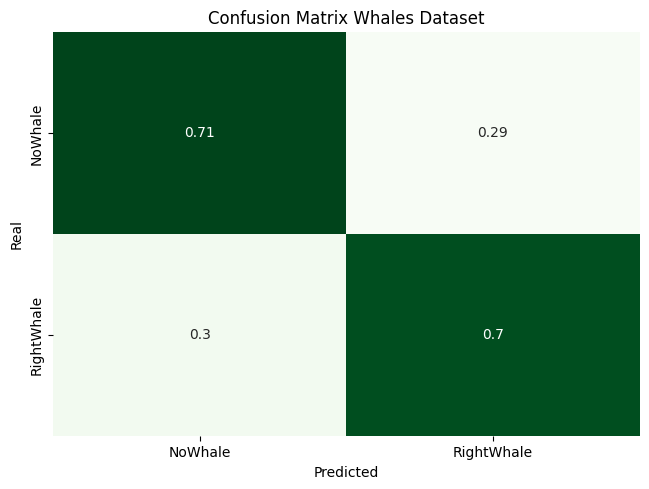

In [ ]:
matriz_confusion(y_train_lr_20, np.array(res), "Whales Dataset")

## Prueba con audios de Test
Para subida a Kaggle

In [ ]:
res = dt_predict(x_train_norm_20, y_train_lr_20, x_test_lr)
#score = accuracy_score(y_test_lr, np.array(res))

DT 1
DT 2
DT 3
DT 4


In [ ]:
results_df = pd.DataFrame({'idx': range(len(res)), 'class': ["RightWhale" if x == 0 else "NoWhale" for x in res]})
results_df.to_csv('predictions_dt.csv', index=False)

# KNN Approach

In [ ]:
from scipy.spatial.distance import cdist
from collections import Counter

In [ ]:
def testing_knn(X_train, y_train, X_test, k):
    distancias = cdist(X_test, X_train, metric='cityblock')
    y_pred = []
    for dist in distancias:
        cercanos = np.argsort(dist)[:k]
        votes = y_train[cercanos]
        max_comun = Counter(votes).most_common(1)[0][0]
        y_pred.append(max_comun)
    return y_pred

In [ ]:
k = 9
y_pred_KNN = testing_knn(x_train_norm_80, y_train_lr_80, x_train_norm_20, k)

In [ ]:
y_test_np = y_train_lr_20 # note (20% destinado)
y_pred_labels_np = np.array(y_pred_KNN)

# Calcula las métricas
precision = precision_score(y_test_np, y_pred_labels_np)
recall = recall_score(y_test_np, y_pred_labels_np)
f1 = f1_score(y_test_np, y_pred_labels_np)

print("\nPrecision:", precision)
print("Recall:", recall)
print("F1-score:", f1)


Precision: 0.7470389170896785
Recall: 0.8252336448598131
F1-score: 0.7841918294849023


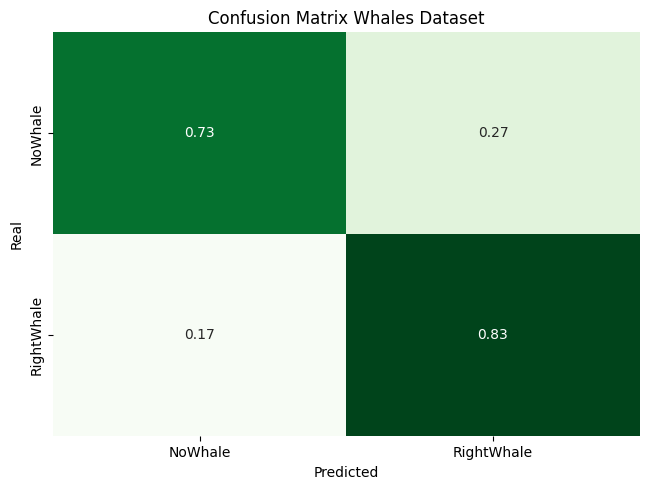

In [ ]:
matriz_confusion(y_train_lr_20, y_pred_labels_np, "Whales Dataset")

## Prueba con audios de Test
Para subida a Kaggle

In [ ]:
k = 9
y_pred_KNN = testing_knn(x_train_norm, y_train_lr, x_test_norm, k)

In [ ]:
label_map_inv = {0: 'NoWhale', 1: 'RightWhale'}
y_pred_classes = [label_map_inv[label] for label in y_pred_KNN]

results_df = pd.DataFrame({
    'idx': [i for i in range(len(y_pred_classes))],
    'class': y_pred_classes
})

results_df.to_csv('/content/drive/MyDrive/P4/Whales Dataset/test_predictions_KNN.csv', index=False)